# How to: Build a simple neural network with TensorFlow Eager

Hello everyone! In this tutorial I am going to build a simple feedforward neural network using the imperative mode of TensorFlow. Hope you will find it useful!

## Step 1: Import useful libraries and enable eager mode
----

In [1]:
# Suppress future warnings
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import TensorFlow and TensorFlow Eager
import tensorflow as tf
import tensorflow.contrib.eager as tfe

# Import function to generate toy classication problem
from sklearn.datasets import make_classification

# Import library for plots
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Enable eager mode
tfe.enable_eager_execution()

## Step 2: Generate toy dataset for multi-classification
----

In [133]:
# Generate toy dataset for classification
# X is a matrix of n_samples x n_features and represents the input features
# y is a vector with length n_samples and represents our targets
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0,
                           random_state=1990, n_clusters_per_class=1,
                           n_classes=3)

## Step 3: Visualize generated dataset
----

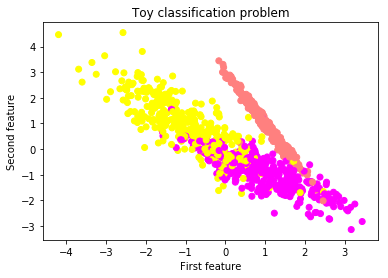

In [135]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.spring)
plt.xlabel('First feature')
plt.ylabel('Second feature')
plt.title('Toy classification problem')
plt.show()

## Step 4: Build a single hidden layer neural  network (Linear -> ReLU -> Linear output)
----
Our first trial is a simple neural network with a single hidden layer. The batchnornm layer is put before the ReLU activation.

In [124]:
# Transfer data from numpy arrays to tensorflow tensors
X = tf.constant(X)
y = tf.constant(y)

In [125]:
class simple_nn():
    def __init__(self):
        # Initialize hidden layer.
        self.dense_layer = tf.layers.Dense(50, activation=tf.nn.relu)
        # Output layer. Unscaled log probabilities.
        self.output_layer = tf.layers.Dense(3, activation=None)
    
    def predict(self, X):
        layer_1 = self.dense_layer(X)
        layer_2 = self.output_layer(layer_1)
        return layer_2

## Step 5: Define loss and optimizer
----
As this is a multi-classification problem, we will be using the softmax cross-entropy loss. Normally, we would have to one-hot encode our targets. To avoid this, we will be using the sparse softmax loss, which takes as an input the raw targets. No need for further processing! HOORAY :smile:.


In [126]:
model = simple_nn()

In [127]:
# Define loss functon
def loss_model(model, X, y):
    output = model.predict(X)
    return tf.losses.sparse_softmax_cross_entropy(y, output)

In [128]:
# Define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)

In [129]:
# Compute the gradients with respect to the loss function
grads = tfe.implicit_gradients(loss_model)(model, X, y)

## Step 6: Train the model with gradient descent
----

In [131]:
num_epochs = 2000

for i in range(num_epochs):
    # One step of gradient descent
    optimizer.apply_gradients(grads)
    # Compute the loss
    if i%50==0:
        print('Loss at step %d: %f' %(i, loss_model(model, X, y).numpy()))

Loss at step 0: 1.104004
Loss at step 50: 1.047813
Loss at step 100: 0.996167
Loss at step 150: 0.949007
Loss at step 200: 0.906186
Loss at step 250: 0.867436
Loss at step 300: 0.832488
Loss at step 350: 0.801028
Loss at step 400: 0.772827
Loss at step 450: 0.747614
Loss at step 500: 0.724996
Loss at step 550: 0.704637
Loss at step 600: 0.686309
Loss at step 650: 0.669809
Loss at step 700: 0.654996
Loss at step 750: 0.641715
Loss at step 800: 0.629875
Loss at step 850: 0.619327
Loss at step 900: 0.609954
Loss at step 950: 0.601677
Loss at step 1000: 0.594367
Loss at step 1050: 0.587920
Loss at step 1100: 0.582273
Loss at step 1150: 0.577382
Loss at step 1200: 0.573191
Loss at step 1250: 0.569590
Loss at step 1300: 0.566529
Loss at step 1350: 0.563982
Loss at step 1400: 0.561934
Loss at step 1450: 0.560334
Loss at step 1500: 0.559222
Loss at step 1550: 0.558647
Loss at step 1600: 0.558573
Loss at step 1650: 0.558967
Loss at step 1700: 0.559819
Loss at step 1750: 0.561122
Loss at step 18

## Step 7: Plot decision function
----

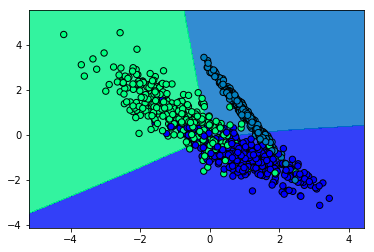

In [132]:
# Create a mesh to plot in
x_min, x_max = X[:, 0].numpy().min() - 1, X[:, 0].numpy().max() + 1
y_min, y_max = X[:, 1].numpy().min() - 1, X[:, 1].numpy().max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predict target for each sample xx, yy
Z = np.argmax(model.predict(tf.constant(np.c_[xx.ravel(), yy.ravel()])).numpy(), axis=1)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.winter, alpha=0.8)

# Plot our training points
plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(), c=y, s=40, cmap=plt.cm.winter, edgecolors='k')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()